This Notebook consists of SINDy applied to simple linear and nonlinear dynamical systems. In each instance the SINDy object is given measurements of state variables, but not their derivatives, and is tasked with identifying the equations to describe their dynamics.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from pysindy.utils import linear_damped_SHO
from pysindy.utils import cubic_damped_SHO
from pysindy.utils import linear_3D
from pysindy.utils import hopf
from pysindy.utils import lorenz

import pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# Linear 2D ODE 

 The first example shows a demonstration of SINDy on a linear two-dimensional damped harmonic oscillator.
     We generate training data by integrating the following linear system of differential equations with initial condition (2, 0) and fit a SINDy model to the training data, finding that it recovers the correct governing equations.

\begin{split}\frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x \\ y\end{bmatrix}\end{split}

In [2]:
# Generate training data

dt = 0.01
t_train = np.arange(0, 25, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0]
x_train = solve_ivp(linear_damped_SHO, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

In [3]:
# Fit the model

poly_order = 5
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt)
model.print()   

(x0)' = -0.100 x0 + 2.000 x1
(x1)' = -2.000 x0 + -0.100 x1


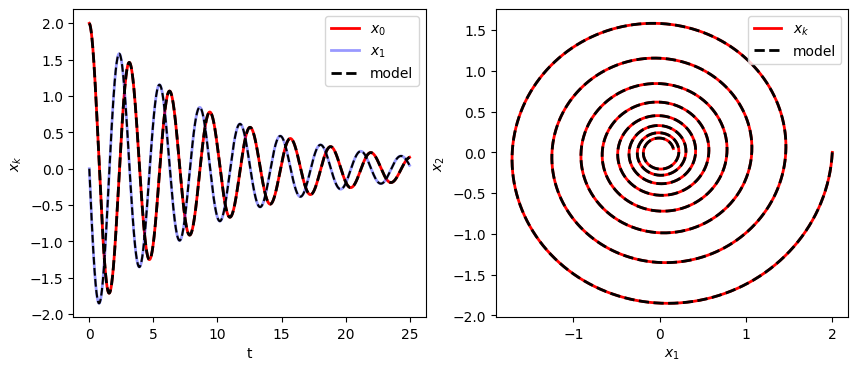

In [4]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

# Cubic 2D ODE

SINDy can also identify a nonlinear two-dimensional damped harmonic oscillator. This example involves cubic dynamics. The governing system used to generate training data is as follows. It is identical to the previous example except the linear terms in the right-hand side have been replaced with cubic ones.

\begin{split}\frac{d}{dt}\begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}-0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x^3 \\ y^3\end{bmatrix}\end{split}

In [5]:
# Generate training data

dt = 0.01
t_train = np.arange(0, 25, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0]
x_train = solve_ivp(cubic_damped_SHO, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

In [6]:
# Fit the model

poly_order = 5
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.100 x0^3 + 1.999 x1^3
(x1)' = -1.999 x0^3 + -0.100 x1^3


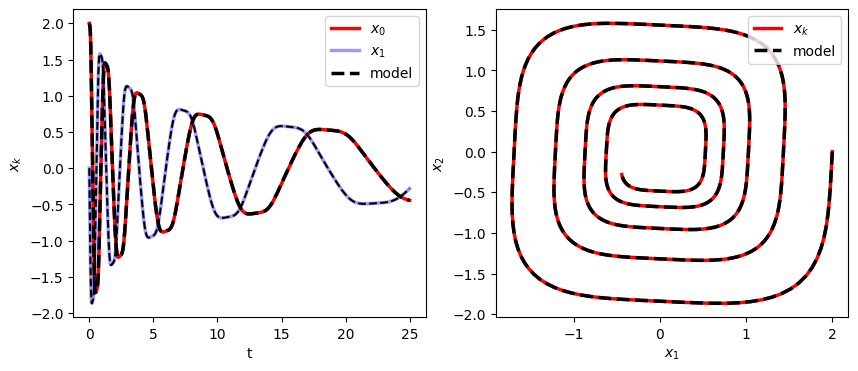

In [7]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2.5)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

# Lorenz system (nonlinear ODE)


 This serves as an example of a nonlinear ODE whose solutions exhibit chaotic dynamics evolving on a strange attractor. The Lorenz system is given by

 \begin{split}\begin{aligned} \dot x &= \sigma(y-x)\\ \dot y &= x(\rho - z) - y \\ \dot z &= xy - \beta z, \end{aligned}\end{split}
 with $\sigma=10 , \rho=28 and \beta=8/3$. for this example. We generate our training data starting from the initial condition (-8, 8, 27) 
. Note that for this example we also collect measurements of derivatives of state variables,$(\dot x, \dot y, \dot z)$
.

In [8]:
# Generate training data

dt = 0.001
t_train = np.arange(0, 100, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T
x_dot_train_measured = np.array(
    [lorenz(0, x_train[i]) for i in range(t_train.size)]
)

Measure states $\ x$ and derivatives $\dot x$ : In this example, both the states 
 and derivatives 
 of the Lorenz system are measures, and increasing levels of noise ($ \eta $
) are added to the derivatives.

In [15]:
# Fit the models and simulate

poly_order = 5
threshold = 0.05

noise_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]

models = []
t_sim = np.arange(0, 20, dt)
x_sim = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(
        x_train,
        t=dt,
        x_dot=x_dot_train_measured
        + np.random.normal(scale=eps, size=x_train.shape),
        quiet=True,
    )
    models.append(model)
    x_sim.append(model.simulate(x_train[0], t_sim))
    for model in models:
        print("Model with noise level: ", eps)
        model.print()
        


Model with noise level:  0.0001
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1
Model with noise level:  0.001
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1
Model with noise level:  0.001
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1
Model with noise level:  0.01
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1
Model with noise level:  0.01
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1
Model with noise level:  0.01
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1
Model with noise level:  0.1
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1
Model with noise level:  0.1
(x

<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:30: SyntaxWarning: invalid escape sequence '\e'
<>:43: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:30: SyntaxWarning: invalid escape sequence '\e'
<>:43: SyntaxWarning: invalid escape sequence '\e'
C:\Users\bhuva\AppData\Local\Temp\ipykernel_66668\767255506.py:16: SyntaxWarning: invalid escape sequence '\e'
  plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
C:\Users\bhuva\AppData\Local\Temp\ipykernel_66668\767255506.py:22: SyntaxWarning: invalid escape sequence '\e'
  plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
C:\Users\bhuva\AppData\Local\Temp\ipykernel_66668\767255506.py:30: SyntaxWarning: invalid escape sequence '\e'
  plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
C:\Users\bhuva\AppData\Local\Temp\ipykernel_66668\767255506.py

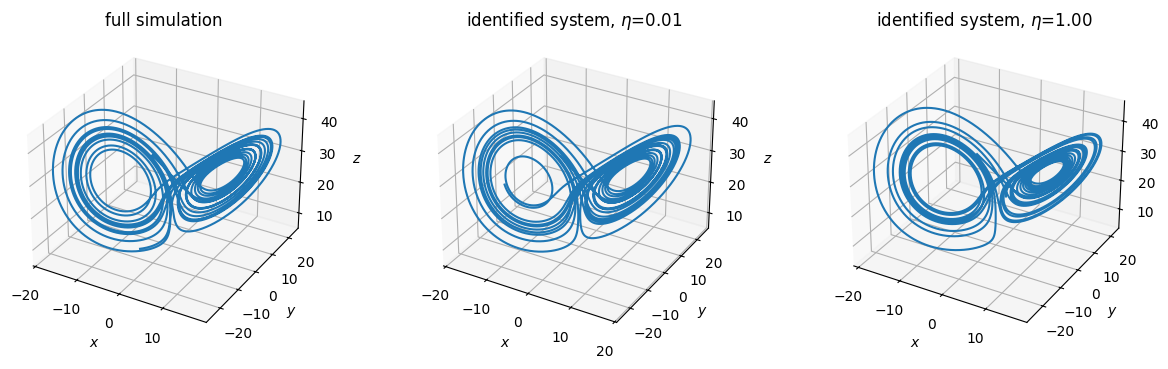

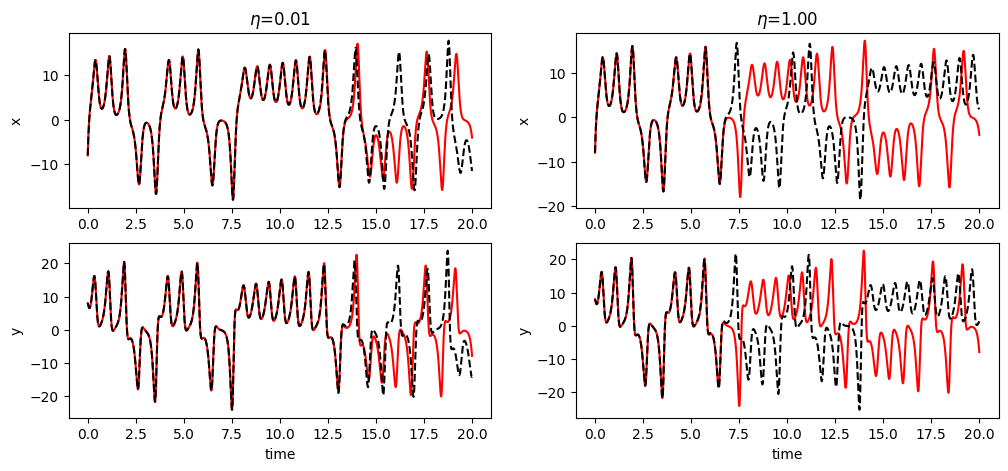

In [11]:
# Plot results

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_train[: t_sim.size, 0],
    x_train[: t_sim.size, 1],
    x_train[: t_sim.size, 2],
)
plt.title("full simulation")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 2
ax = fig.add_subplot(132, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 4
ax = fig.add_subplot(133, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

fig = plt.figure(figsize=(12, 5))
model_idx = 2
ax = fig.add_subplot(221)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(223)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

model_idx = 4
ax = fig.add_subplot(222)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(224)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

fig.show()

Measure only the states 
$\ x $, compute the derivatives :
In this example, only the states 
 are measured and noise at different levels is added to the states. Derivatives are computed from the noisy state measurements using a centered difference scheme.

In [12]:
# Fit the models and simulate

noise_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]

models_noD = []
t_sim = np.arange(0, 20, dt)
x_sim_noD = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(x_train + np.random.normal(scale=eps, size=x_train.shape),
              t=dt, quiet=True)
    models_noD.append(model)
    x_sim_noD.append(model.simulate(x_train[0], t_sim))

we plot the error as a function of time for varying levels of noise.

<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bhuva\AppData\Local\Temp\ipykernel_66668\1954910559.py:11: SyntaxWarning: invalid escape sequence '\d'
  axs[0].set(xlabel="time", title="measure $x$ and $\dot{x}$")
C:\Users\bhuva\AppData\Local\Temp\ipykernel_66668\1954910559.py:23: SyntaxWarning: invalid escape sequence '\d'
  axs[1].set(xlabel="time", title="measure $x$, compute $\dot{x}$")


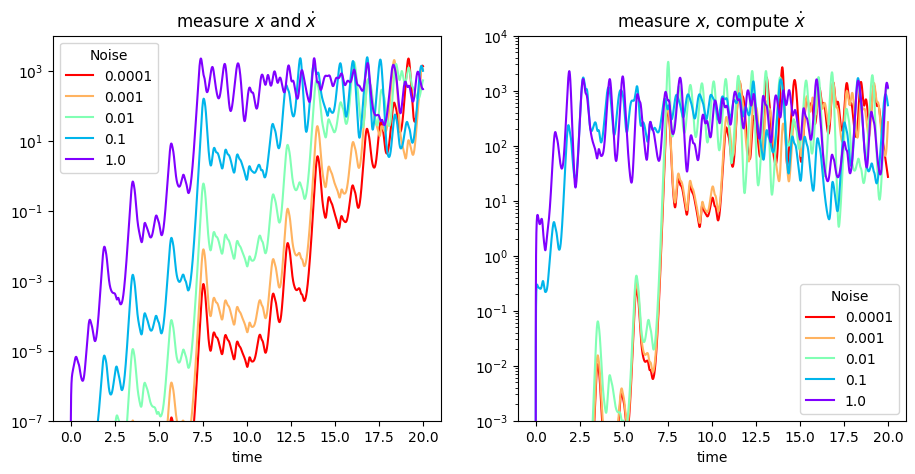

In [13]:
colors = rainbow(np.linspace(1, 0, len(models)))

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
for i, x in enumerate(x_sim):
    axs[0].semilogy(
        t_sim,
        np.sum((x - x_train[: t_sim.size]) ** 2, axis=1),
        color=colors[i],
        label=noise_levels[i],
    )
axs[0].set(xlabel="time", title="measure $x$ and $\dot{x}$")
axs[0].legend(title="Noise")
axs[0].set_ylim(1e-7, 1e4)

for i, x in enumerate(x_sim_noD):
    axs[1].semilogy(
        t_sim,
        np.sum((x - x_train[: t_sim.size]) ** 2, axis=1),
        color=colors[i],
        label=noise_levels[i],
    )

axs[1].set(xlabel="time", title="measure $x$, compute $\dot{x}$")
axs[1].legend(title="Noise")
axs[1].set_ylim(1e-3, 1e4)

fig.show()